In [45]:
!pip install scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/aa/ce/c0b912f2f31aeb1b756a6ba56bcd84dd1f8a148470526a48515a3f4d48cd/scikit_learn-1.5.2-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/91/29/df4b9b42f2be0b623cbd5e2140cafcaa2bef0759a00b7b70104dcfe2fb51/joblib-1.4.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=3.1.0 from https://files.pythonhosted.org/packages/4b/2c/ffbf7a134b9ab11a67b0cf0726453cedd9c5043a4fe7a35d1cefa9a1bcfb/threadpoolctl-3.5.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   -- ------------------------------------- 0.7/11.0 MB 14.2 MB/s eta 0:00:01
   ------------------ --------------------- 5.1/11.0 MB 55.2 MB/s eta 0:00:01
   -------------------------------------- - 10.7/11.0 MB 110.0 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [231]:

import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from sklearn.preprocessing import TargetEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.tree import plot_tree

# Loading Data from DB

In [2]:
host = 'localhost'  # Use explicit IP address
port = '5432'
database = 'postgres'
user = 'postgres'
password = 'Ebola101!'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}'

# Establish the connection
engine = create_engine(connection_string)

try:
    with engine.connect() as connection:
        print("Connected to PostgreSQL database successfully!")
except Exception as e:
    print("Error connecting to PostgreSQL database:", e)

Connected to PostgreSQL database successfully!


In [60]:
table_name = "kingco_sales"

In [126]:
kingco_sales = pd.read_sql(f"SELECT * FROM {table_name}", engine)

# Null Values

dropping null rows as imputing their values negatively impacts the model

In [127]:
kingco_sales = kingco_sales.drop(columns=['sale_year','sale_date', 'join_year', 'sale_id', 'pinx', 'sale_nbr', 'sale_warning', 'join_status', 'Unnamed: 0'])

In [129]:
kingco_sales = kingco_sales.dropna()

In [253]:
kingco_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 519982 entries, 0 to 574117
Data columns (total 42 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   latitude                 519982 non-null  float64
 1   longitude                519982 non-null  float64
 2   area                     519982 non-null  int64  
 3   city                     519982 non-null  object 
 4   subdivision              519982 non-null  object 
 5   present_use              519982 non-null  int64  
 6   land_val                 519982 non-null  int64  
 7   imp_val                  519982 non-null  int64  
 8   year_built               519982 non-null  int64  
 9   year_reno                519982 non-null  int64  
 10  sqft_lot                 519982 non-null  int64  
 11  sqft                     519982 non-null  int64  
 12  sqft_1                   519982 non-null  int64  
 13  sqft_fbsmt               519982 non-null  int64  
 14  grade    

Getting rid of values which hold no importance

# Outlier Reduction

In [ ]:
# Assuming you have your DataFrame 'kingco_sales'

# Calculate the quartiles
Q1 = kingco_sales['adjusted_sale_price'].quantile(0.25)
Q3 = kingco_sales['adjusted_sale_price'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
kingco_sales_cleaned = kingco_sales[(kingco_sales['adjusted_sale_price'] >= lower_bound) & (kingco_sales['adjusted_sale_price'] <= upper_bound)] 

In [134]:
kingco_sales_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515149 entries, 0 to 574117
Data columns (total 42 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   latitude                 515149 non-null  float64
 1   longitude                515149 non-null  float64
 2   area                     515149 non-null  int64  
 3   city                     515149 non-null  object 
 4   subdivision              515149 non-null  object 
 5   present_use              515149 non-null  int64  
 6   land_val                 515149 non-null  int64  
 7   imp_val                  515149 non-null  int64  
 8   year_built               515149 non-null  int64  
 9   year_reno                515149 non-null  int64  
 10  sqft_lot                 515149 non-null  int64  
 11  sqft                     515149 non-null  int64  
 12  sqft_1                   515149 non-null  int64  
 13  sqft_fbsmt               515149 non-null  int64  
 14  grade    

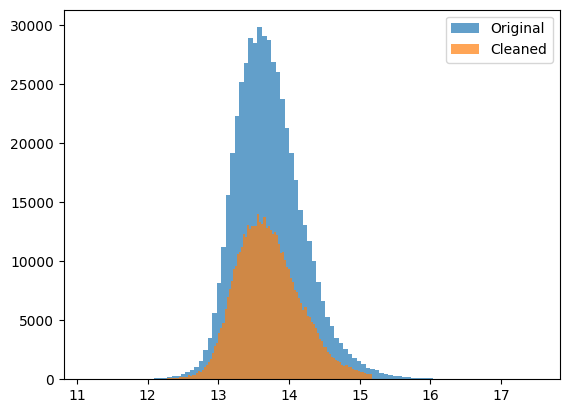

In [ ]:


# Plot histogram of the log-transformed variable
plt.hist(kingco_sales['adjusted_sale_price'], bins=100, alpha=0.7, label='Original')
plt.hist(kingco_sales_cleaned['adjusted_sale_price'], bins=100, alpha=0.7, label='Cleaned')
plt.legend()
plt.show()


In [255]:
kingco_sales_cleaned.to_sql("kingco_sales_cleaned", engine, if_exists='replace', index=False)

113

# Encoding

In [ ]:
geographic_columns = ['latitude', 'longitude', 'area', 'city', 'subdivision', 'submarket','zoning_type', 'present_use', 'adjusted_sale_price']

valuation_columns = ['land_val', 'imp_val', 'adjusted_sale_price']
property_characteristics_columns = [
    'year_built', 'year_reno', 'sqft_lot', 'sqft', 'sqft_1', 'sqft_fbsmt',
    'stories', 'beds', 'bath_full', 'bath_3qtr', 'bath_half',
    'garb_sqft', 'gara_sqft', 'adjusted_sale_price'
]
quality_condition_columns = ['grade', 'fbsmt_grade', 'condition', 'adjusted_sale_price']
features_columns = [
    'wfnt', 'golf', 'greenbelt', 'noise_traffic', 'view_rainier', 'view_olympics',
    'view_cascades', 'view_territorial', 'view_skyline', 'view_sound',
    'view_lakewash', 'view_lakesamm', 'view_otherwater', 'view_other', 'adjusted_sale_price'
]

# Create subdataframes
df_geographic = kingco_sales_cleaned[geographic_columns]
df_valuation = kingco_sales_cleaned[valuation_columns]
df_property_characteristics = kingco_sales_cleaned[property_characteristics_columns]
df_quality_condition = kingco_sales_cleaned[quality_condition_columns]
df_features = kingco_sales_cleaned[features_columns]

In [137]:

df_geographic_encoded = pd.get_dummies(df_geographic, columns=['present_use','zoning_type'], drop_first=True)

In [ ]:
target_columns = ['area', 'city', 'subdivision', 'submarket']

X = df_geographic_encoded[target_columns]
y = df_geographic_encoded['adjusted_sale_price']

# Initialize the TargetEncoder
target_encoder = TargetEncoder()

# Fit and transform the target columns
X_encoded = target_encoder.fit_transform(X, y)

# Replace the original target columns with the encoded ones

df_geographic_encoded[target_columns] = X_encoded

df_geographic_encoded

,latitude,longitude,area,city,subdivision,submarket,Log_adjusted_sale_price,present_use_6,present_use_29,zoning_type_Manufacturing,zoning_type_Other,zoning_type_Parks,zoning_type_Recreational,zoning_type_Residential,"zoning_type_Transport, Communications, and Public Services",zoning_type_Unknown
0,47.452537,-122.285786,13.306800,13.303285,13.235073,13.313015,13.192107,False,False,False,False,False,False,False,False,True
2,47.582821,-122.387508,13.740498,13.800796,13.843635,13.625870,13.934551,False,False,False,False,False,False,False,False,True
3,47.586412,-122.299785,13.414530,13.800980,13.602202,13.569577,13.516347,False,False,False,False,False,False,False,False,True
4,47.684924,-122.331984,13.965380,13.801019,14.121166,13.806316,14.116873,False,False,False,False,False,False,True,False,False
5,47.467526,-122.269776,13.262872,13.276536,13.168463,13.310998,13.393745,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574113,47.504445,-122.332700,13.262872,13.637123,13.154928,13.310998,13.393745,False,False,False,False,False,False,True,False,False
574114,47.573691,-122.142780,14.134626,13.638451,13.663827,14.054242,13.882592,False,False,False,False,False,False,True,False,False
574115,47.702048,-122.205832,14.240752,13.935542,13.954202,13.888018,13.542914,False,False,False,False,False,False,False,False,True
574116,47.701534,-122.316527,13.655894,13.801490,13.735048,13.869356,13.791937,False,False,False,False,False,False,True,False,False


In [ ]:
# Specify the target columns
# Specify the target columns
target_columns = ['area', 'city', 'subdivision', 'submarket']
target_variable = 'adjusted_sale_price'

# Create a dictionary to store the mappings
mappings = {}

# Compute mean encoding for each column
for col in target_columns:
    # Group by the column and calculate the mean of the target variable
    mapping = df_geographic.groupby(col)[target_variable].mean()
    
    # Convert the result to a dictionary and store it
    mappings[col] = mapping.to_dict()

# Convert mappings to a DataFrame for better readability
mappings_list = []
for col, map_dict in mappings.items():
    mappings_list.extend([(col, key, value) for key, value in map_dict.items()])

mappings_df = pd.DataFrame(mappings_list, columns=['Column', 'Original Value', 'Encoded Value'])

In [274]:
mappings_df

,Column,Original Value,Encoded Value
0,area,1,13.780601
1,area,2,13.503426
2,area,3,13.452547
3,area,4,13.741147
4,area,5,13.678381
...,...,...,...
10760,submarket,O,14.074997
10761,submarket,P,14.022221
10762,submarket,Q,13.888613
10763,submarket,R,14.053034


In [139]:
kingco_sales_encoded = pd.get_dummies(kingco_sales_cleaned, columns=['present_use','zoning_type'], drop_first=True)
kingco_sales_encoded[target_columns] = X_encoded

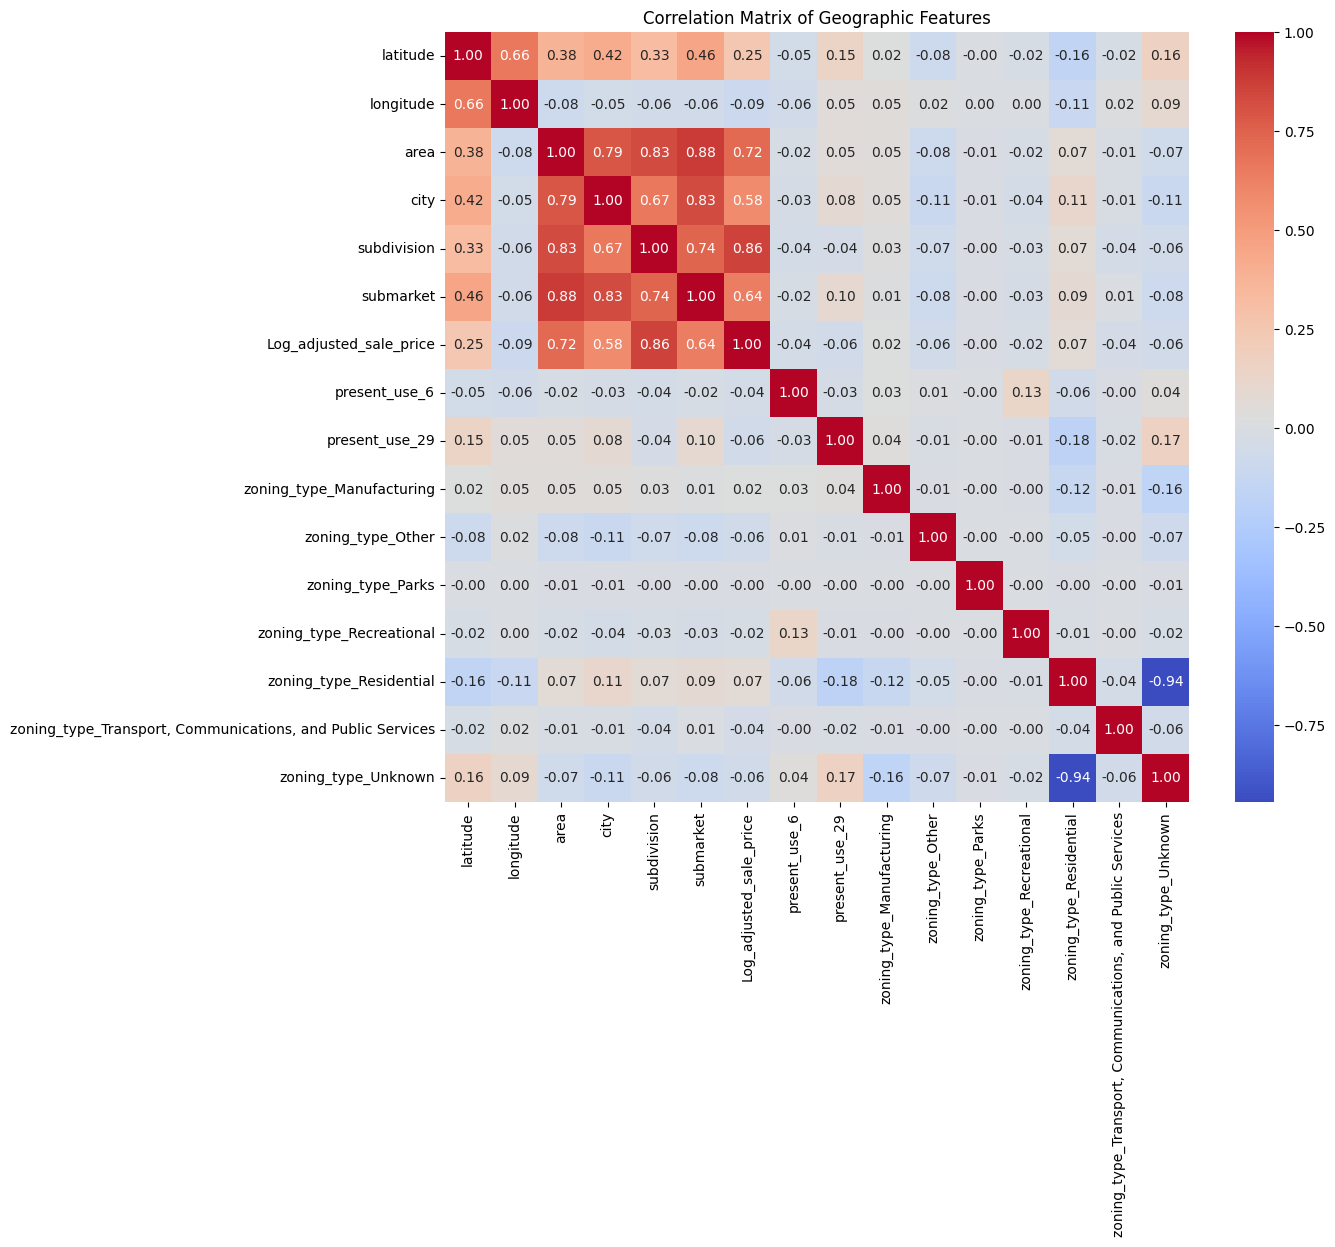

In [140]:
correlation_matrix = df_geographic_encoded.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Geographic Features')
plt.show()

In [ ]:
subset1 =df_geographic_encoded.drop(columns=['adjusted_sale_price'])
pca_subset1 = PCA(n_components=None)
pca_subset1.fit(subset1)

PCA()

In [212]:
explained_variance_subset1 = pca_subset1.explained_variance_ratio_
cumulative_variance_subset1 = np.cumsum(explained_variance_subset1)

# Display results
print("Explained Variance Ratio:", explained_variance_subset1)
print("Cumulative Variance Ratio:", cumulative_variance_subset1)

Explained Variance Ratio: [9.72196587e-01 2.78034133e-02 5.13729320e-12 2.16371768e-12
 7.77760186e-13 3.59389001e-13 3.27410595e-13 1.61774068e-13
 9.48109891e-14 7.64882230e-14 6.07905641e-14 3.27626310e-14
 4.37141279e-15 1.20173339e-15 2.02307716e-16]
Cumulative Variance Ratio: [0.97219659 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ]


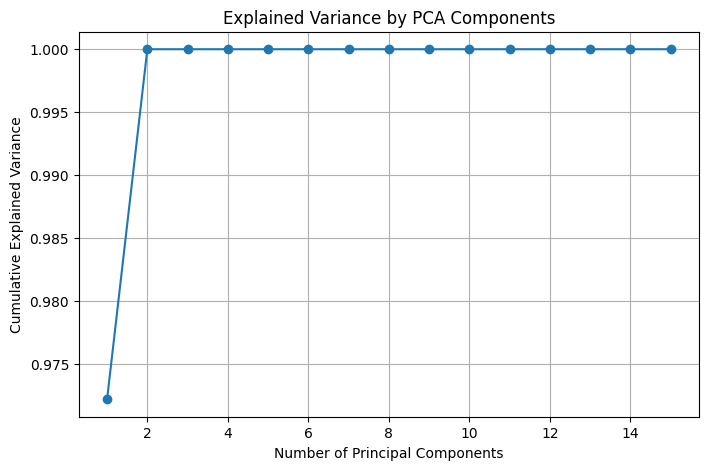

In [213]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance_subset1) + 1), cumulative_variance_subset1, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()

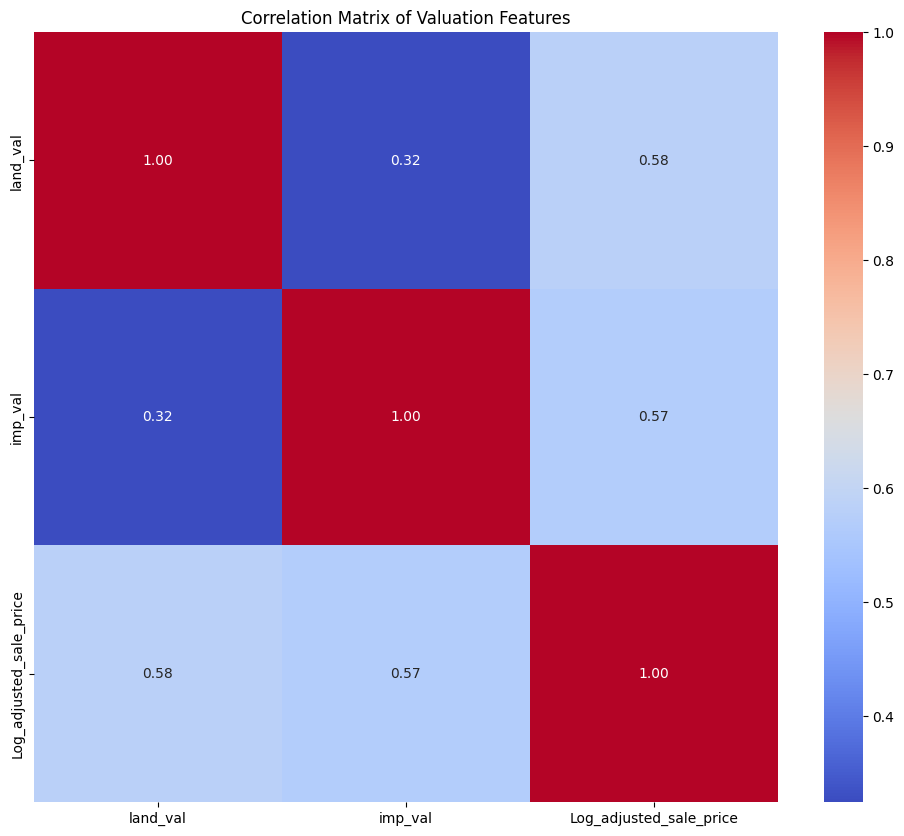

In [262]:
correlation_matrix = df_valuation.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Valuation Features')
plt.show()

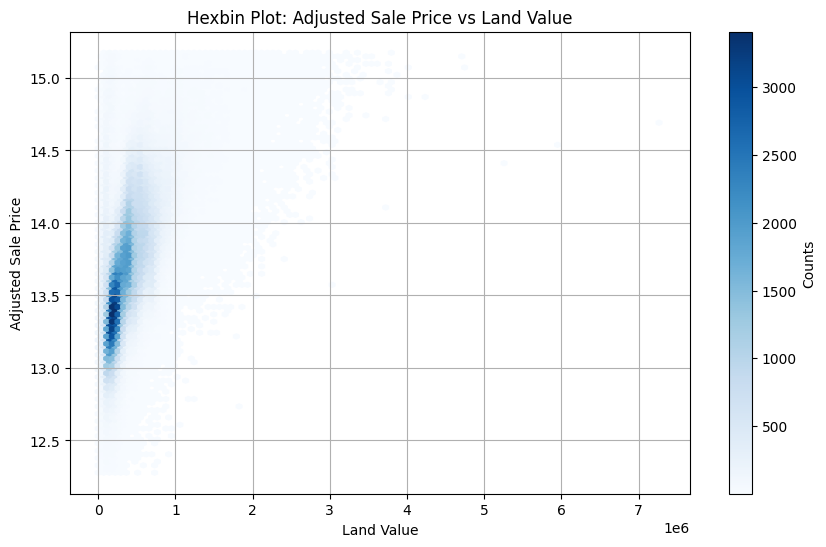

In [ ]:
plt.figure(figsize=(10, 6))
plt.hexbin(df_valuation['land_val'], df_valuation['adjusted_sale_price'], gridsize=100, cmap="Blues", mincnt=1)
plt.colorbar(label='Counts')
plt.xlabel('Land Value')
plt.ylabel('Adjusted Sale Price')
plt.title('Hexbin Plot: Adjusted Sale Price vs Land Value')
plt.grid(True)
plt.show()

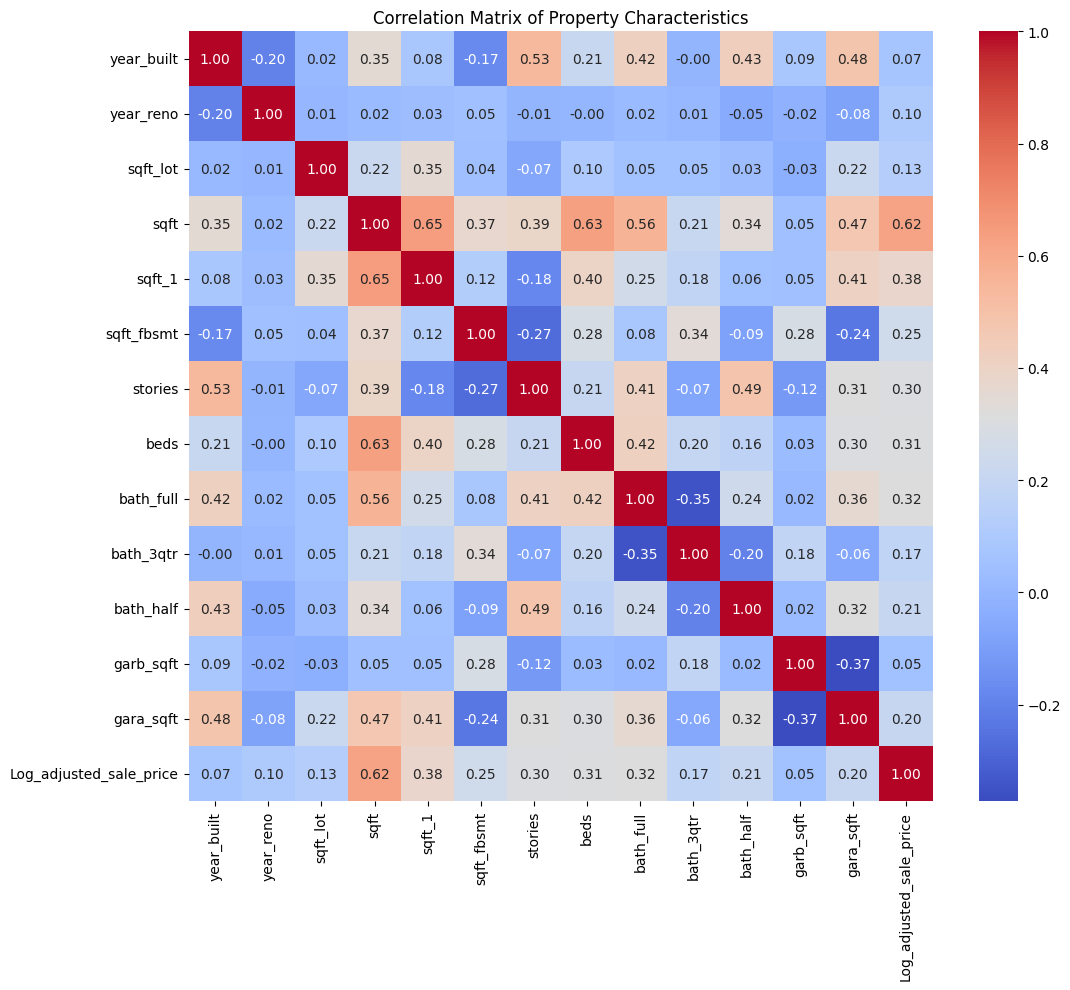

In [142]:
# Calculate the correlation matrix
correlation_matrix = df_property_characteristics.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Property Characteristics')
plt.show()

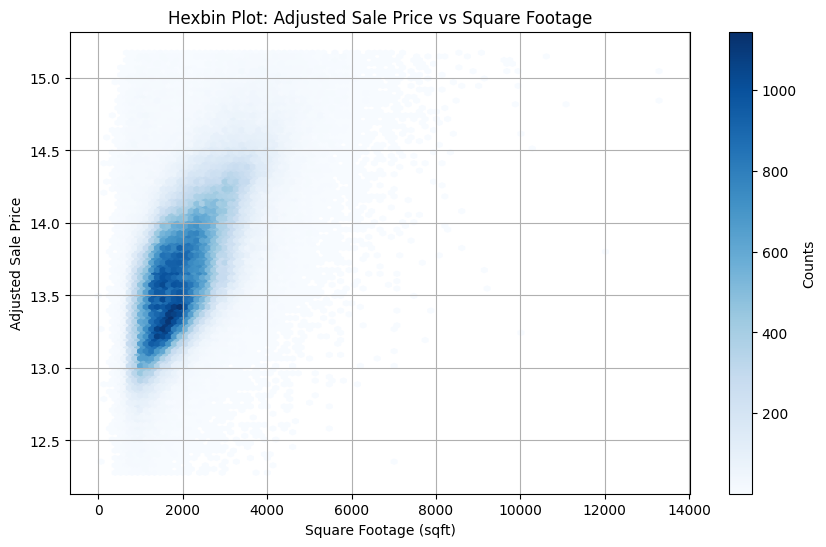

In [ ]:
# Hexbin plot
plt.figure(figsize=(10, 6))
plt.hexbin(df_property_characteristics['sqft'], df_property_characteristics['adjusted_sale_price'],
           gridsize=100, cmap="Blues", mincnt=1)
plt.colorbar(label='Counts')
plt.xlabel('Square Footage (sqft)')
plt.ylabel('Adjusted Sale Price')
plt.title('Hexbin Plot: Adjusted Sale Price vs Square Footage')
plt.grid(True)
plt.show()

In [ ]:
subset1 =df_property_characteristics.drop(columns=['adjusted_sale_price'])
pca_subset1 = PCA(n_components=None)
pca_subset1.fit(subset1)

PCA()

In [215]:
explained_variance_subset1 = pca_subset1.explained_variance_ratio_
cumulative_variance_subset1 = np.cumsum(explained_variance_subset1)

# Display results
print("Explained Variance Ratio:", explained_variance_subset1)
print("Cumulative Variance Ratio:", cumulative_variance_subset1)

Explained Variance Ratio: [9.91903568e-01 5.25208158e-03 1.19704447e-03 6.81047963e-04
 5.57742016e-04 2.74788110e-04 1.30532313e-04 3.18720400e-06
 3.09158270e-09 3.05923734e-09 1.36855770e-09 6.14658995e-10
 3.15376817e-10]
Cumulative Variance Ratio: [0.99190357 0.99715565 0.99835269 0.99903374 0.99959148 0.99986627
 0.9999968  0.99999999 0.99999999 1.         1.         1.
 1.        ]


In [217]:
cumulative_variance_subset1

array([0.99190357, 0.99715565, 0.99835269, 0.99903374, 0.99959148,
       0.99986627, 0.9999968 , 0.99999999, 0.99999999, 1.        ,
       1.        , 1.        , 1.        ])

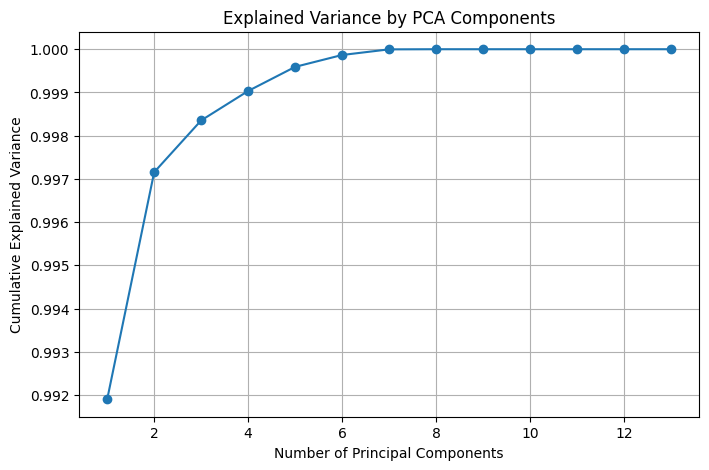

In [216]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance_subset1) + 1), cumulative_variance_subset1, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()

Getting rid of values which hold no importance

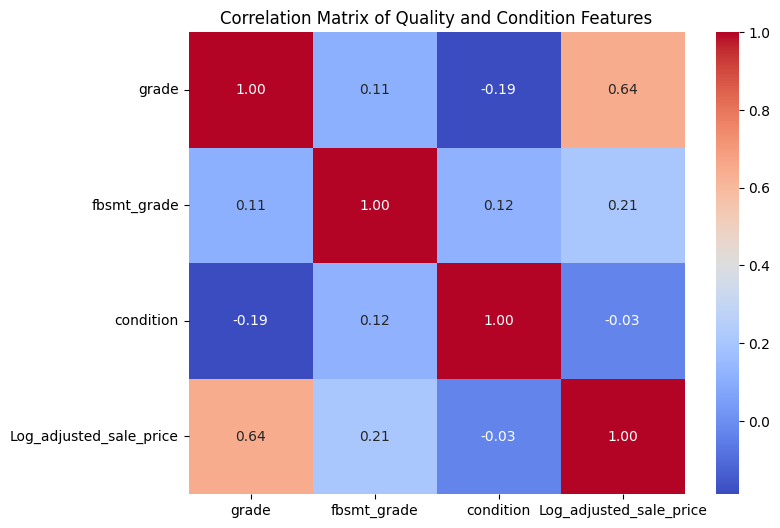

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df_quality_condition.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Quality and Condition Features')
plt.show()

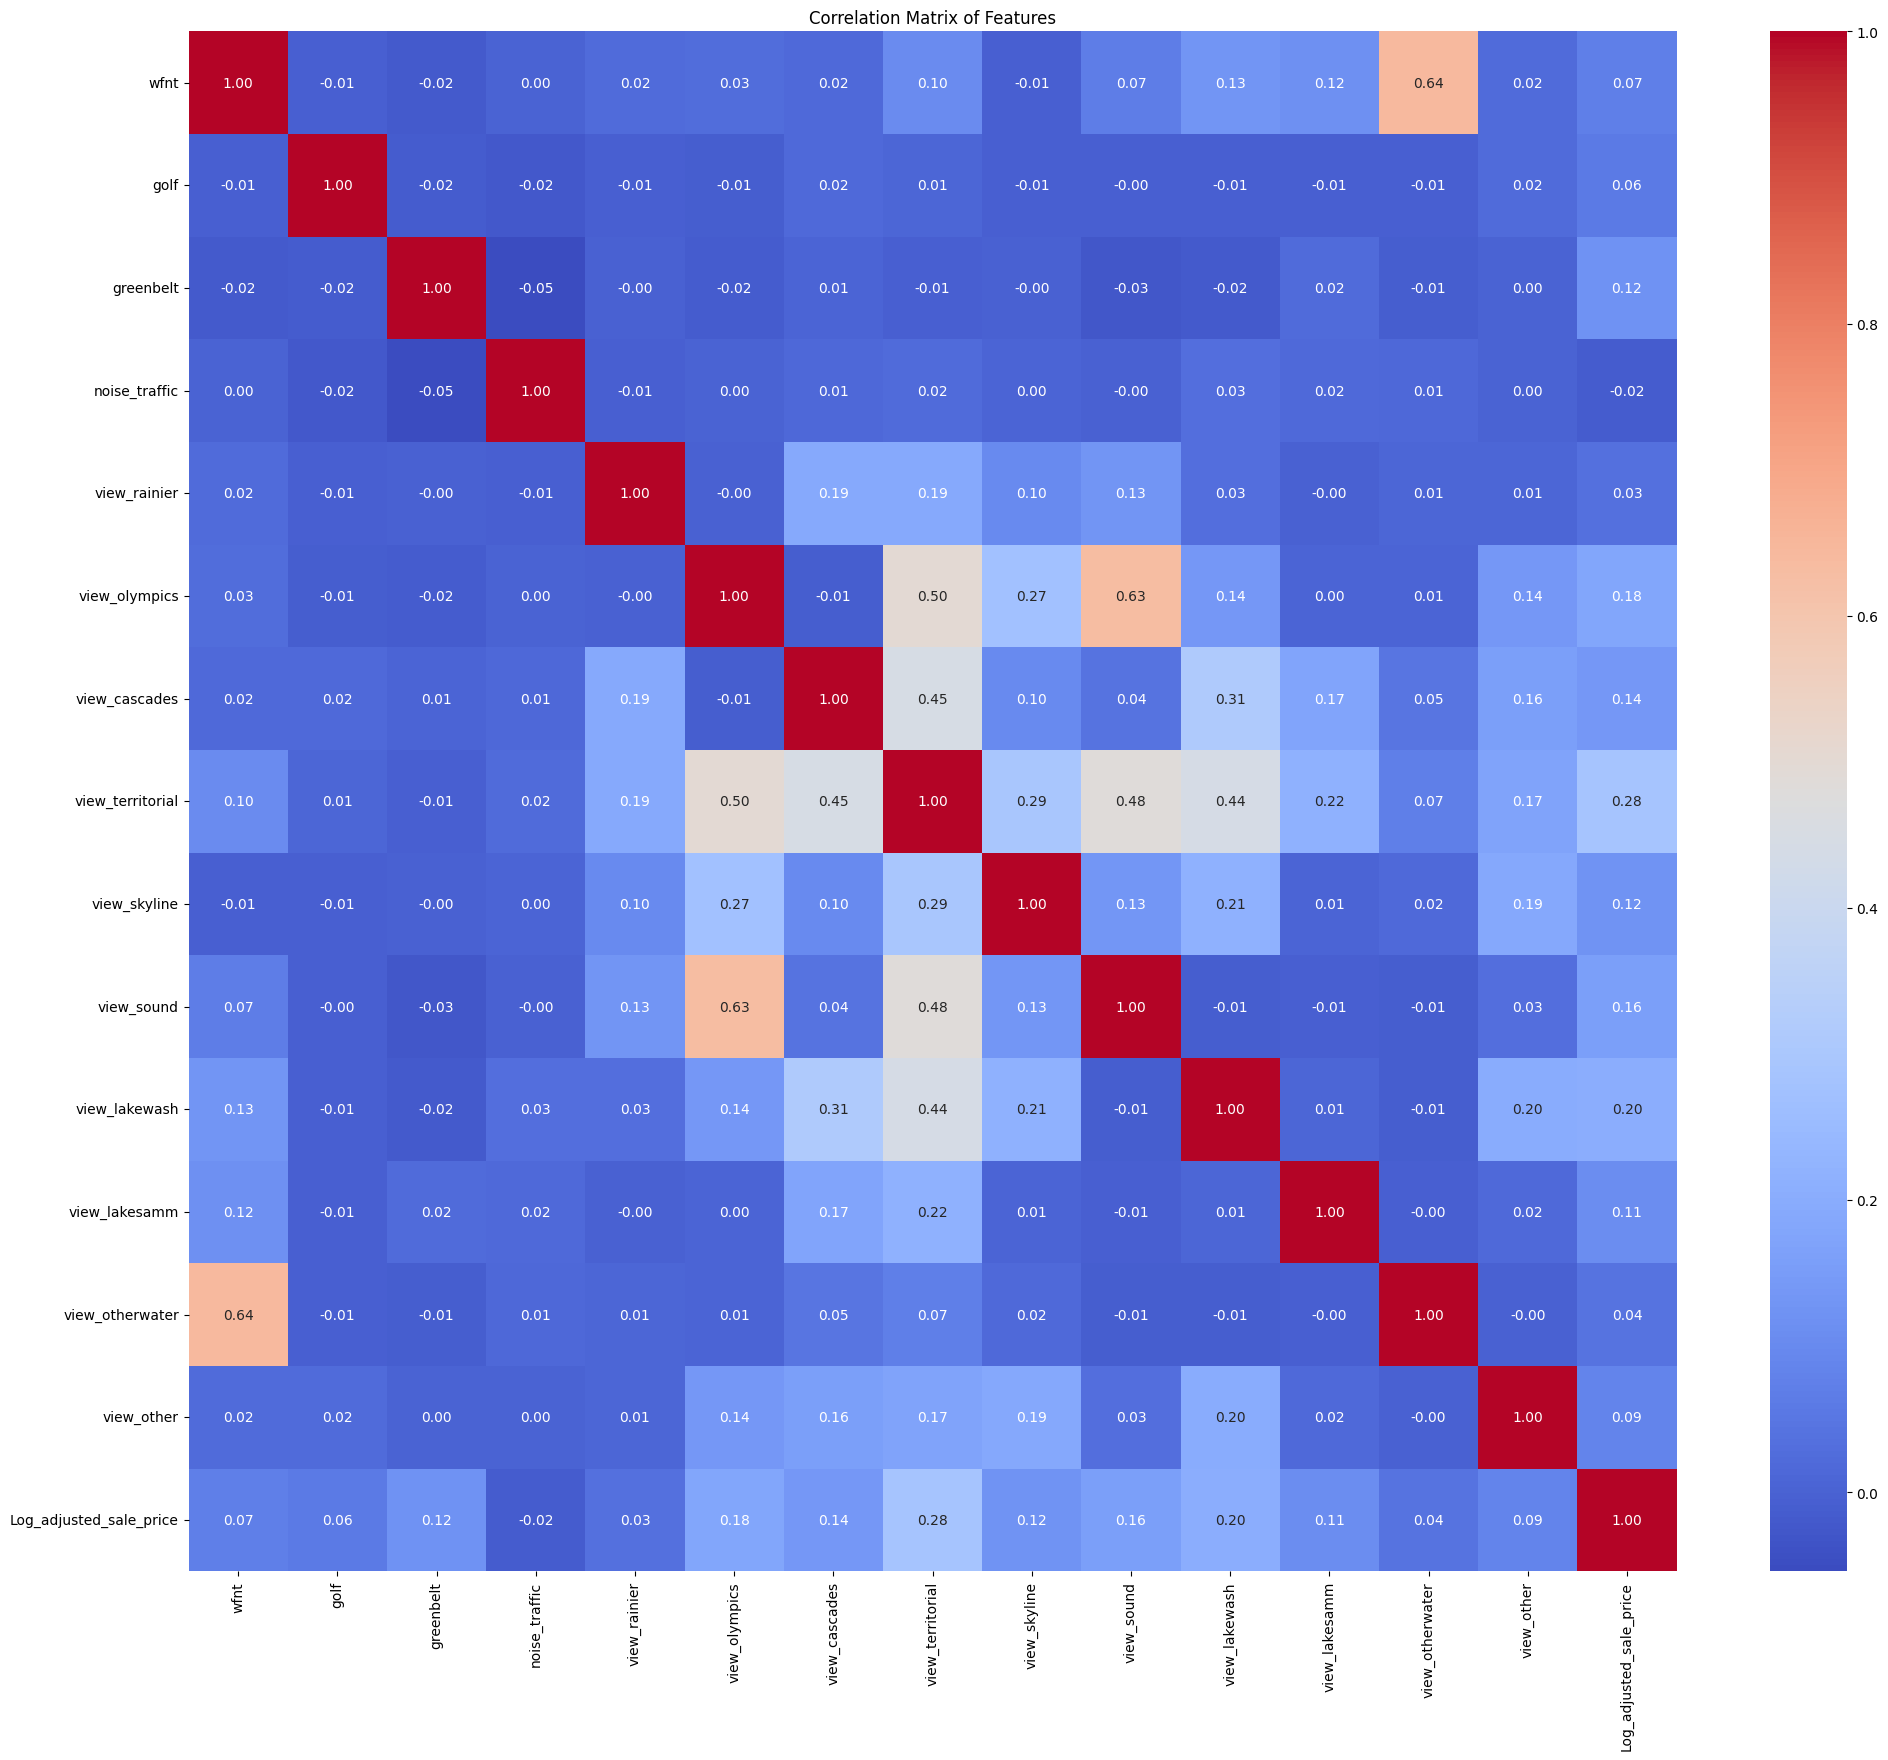

In [144]:
# prompt: correlation matrix for df_features

# Calculate the correlation matrix
correlation_matrix = df_features.corr()

# Create a heatmap
plt.figure(figsize=(24, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

# Scaling

In [145]:
kingco_sales_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515149 entries, 0 to 574117
Data columns (total 49 columns):
 #   Column                                                      Non-Null Count   Dtype  
---  ------                                                      --------------   -----  
 0   latitude                                                    515149 non-null  float64
 1   longitude                                                   515149 non-null  float64
 2   area                                                        515149 non-null  float64
 3   city                                                        515149 non-null  float64
 4   subdivision                                                 515149 non-null  float64
 5   land_val                                                    515149 non-null  int64  
 6   imp_val                                                     515149 non-null  int64  
 7   year_built                                                  515149 non-null  in

In [146]:
X = kingco_sales_encoded.drop(columns=['Log_adjusted_sale_price', 'adjusted_sale_price'])  # Drop the target column from the features
y = kingco_sales_encoded['Log_adjusted_sale_price']  # Define the target

Normalizing the Columns to ensure equal impact

In [147]:
columns_to_normalize = [
    'latitude', 'longitude', 'land_val', 'imp_val', 'year_built', 'year_reno',
    'sqft_lot', 'sqft', 'sqft_1', 'sqft_fbsmt','area','subdivision','submarket','city'
]

In [148]:
scaler = MinMaxScaler()

X_scaled = X.copy()


In [149]:
X_scaled[columns_to_normalize] = scaler.fit_transform(X[columns_to_normalize])

Splitting the sets

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model Testing

In [151]:
gbm = GradientBoostingRegressor(
    n_estimators=100,        # Number of boosting stages
    learning_rate=0.1,       # Learning rate
    max_depth=3,             # Maximum depth of each tree
    random_state=42          # Random seed for reproducibility
)

In [152]:
# Train the model
gbm.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

GradientBoostingRegressor(n_iter_no_change=10, random_state=42)

In [153]:
# Predictions
y_pred = gbm.predict(X_test)

In [154]:
# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")


Mean Squared Error (MSE): 0.036158769683565024
R-squared (R²): 0.8239860811265706


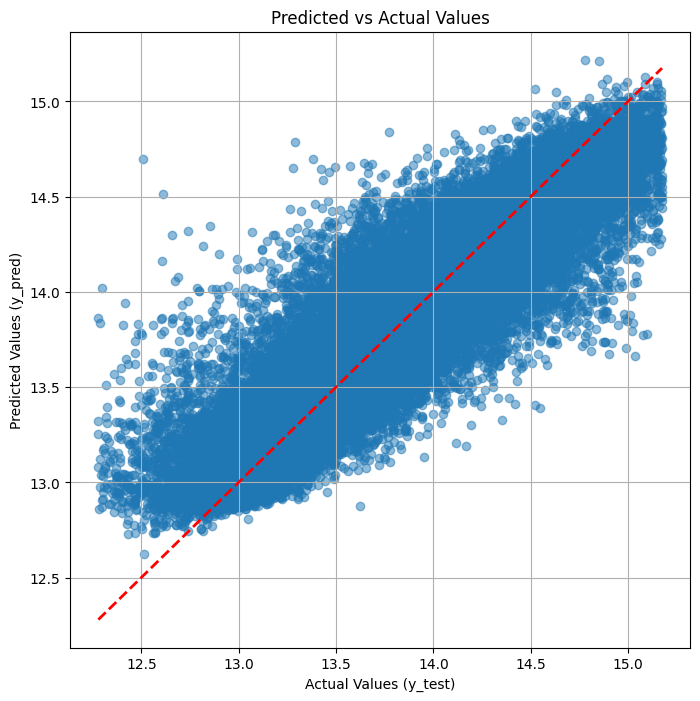

In [155]:
# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Predicted vs Actual Values')
plt.grid()
plt.show()


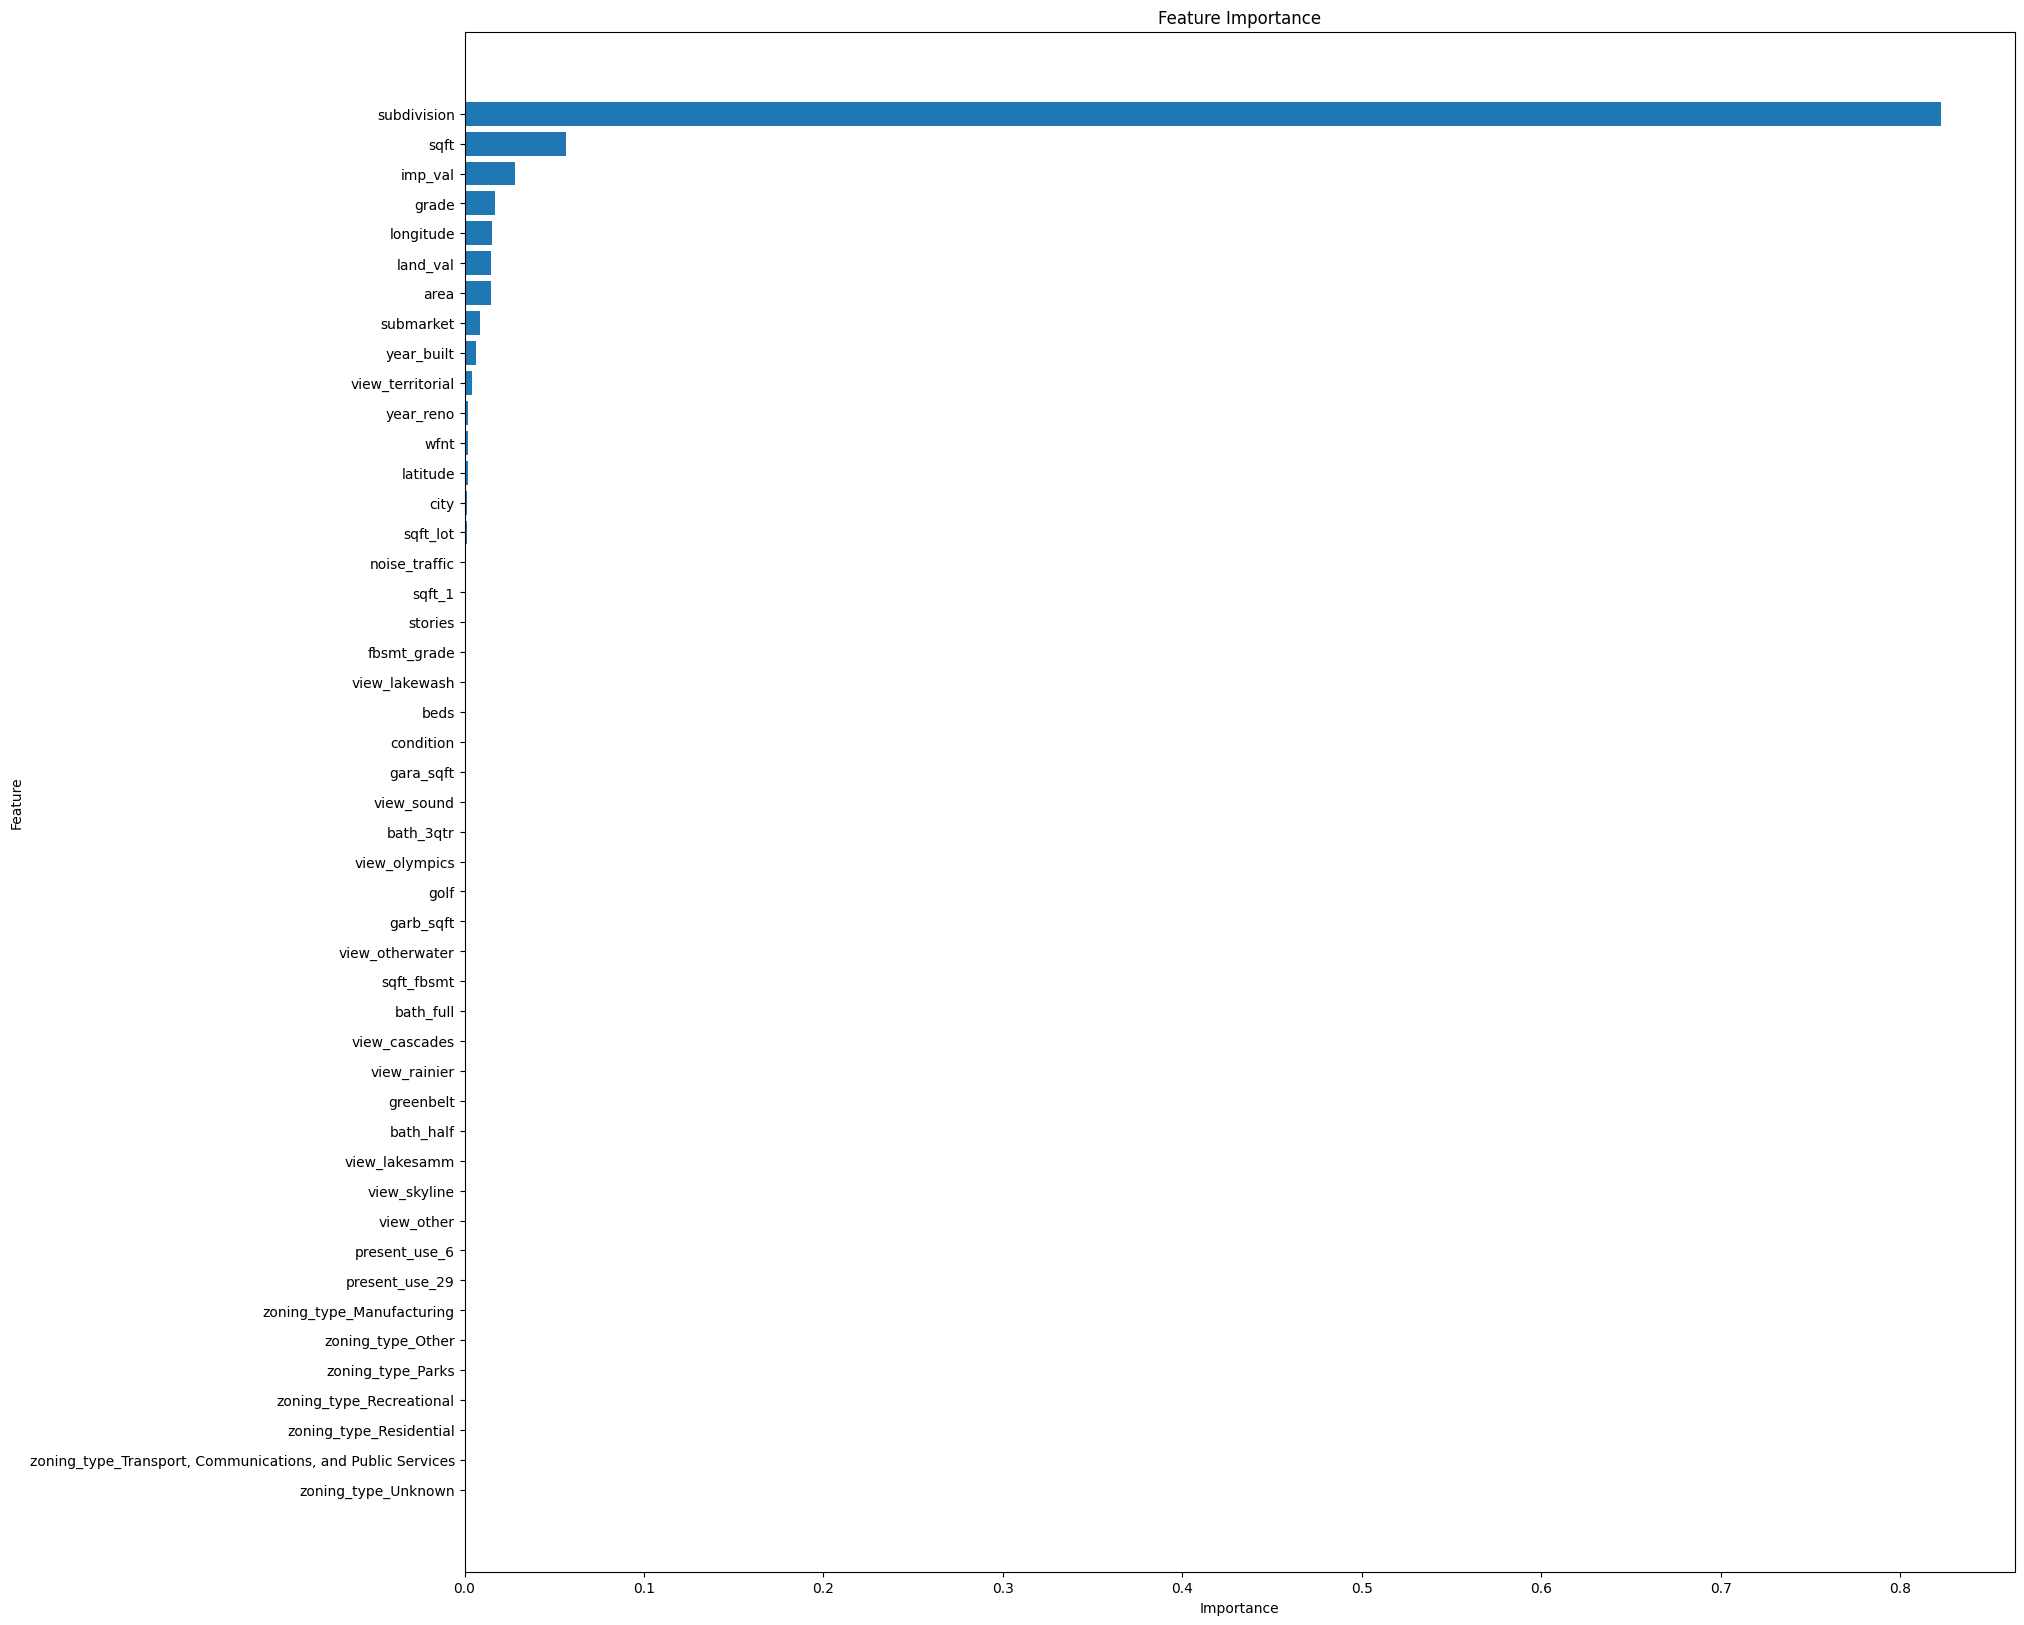

In [156]:
# Sort feature importances
feature_importance = pd.Series(gbm.feature_importances_, index=X_scaled.columns)
sorted_importance = feature_importance.sort_values(ascending=False)

# Plot sorted feature importance
plt.figure(figsize=(20, 20))
plt.barh(sorted_importance.index, sorted_importance.values)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()


In [157]:
sorted_importance

subdivision                                                   0.822606
sqft                                                          0.056466
imp_val                                                       0.028208
grade                                                         0.016963
longitude                                                     0.015102
land_val                                                      0.014930
area                                                          0.014724
submarket                                                     0.008759
year_built                                                    0.006436
view_territorial                                              0.004136
year_reno                                                     0.002171
wfnt                                                          0.002091
latitude                                                      0.001731
city                                                          0.001559
sqft_l

In [181]:
# Convert the Series to a DataFrame
sorted_importance_df = sorted_importance.reset_index()

# Rename the columns
sorted_importance_df.columns = ['Feature', 'Importance']
sorted_importance_df['Importance'] =scaler.fit_transform(sorted_importance_df[['Importance']])
# Display the updated DataFrame
sorted_importance_df

,Feature,Importance
0,subdivision,1.000000
1,sqft,0.068643
2,imp_val,0.034291
3,grade,0.020621
4,longitude,0.018359
5,land_val,0.018150
6,area,0.017899
7,submarket,0.010648
8,year_built,0.007824
9,view_territorial,0.005028


# PCA


In [158]:
pca = PCA()


In [159]:
X_pca = pca.fit_transform(X_scaled)

In [160]:
# Variance explained by each principal component
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)

Explained Variance Ratio: [7.71099011e-01 2.28761761e-01 8.58759279e-05 1.01218512e-05
 6.18625187e-06 5.80813776e-06 4.56514148e-06 4.00091357e-06
 3.82251408e-06 3.55481012e-06 2.50287637e-06 2.19789713e-06
 1.69047375e-06 1.57298373e-06 9.08722747e-07 8.16811322e-07
 7.73607139e-07 6.42911179e-07 5.98585320e-07 4.62835155e-07
 3.95643253e-07 3.84426959e-07 3.22645508e-07 2.84633070e-07
 2.73241879e-07 2.60411311e-07 2.40202350e-07 2.14155416e-07
 1.81405877e-07 1.43634396e-07 6.51659297e-08 6.10487831e-08
 5.73665329e-08 5.28663506e-08 4.82775826e-08 4.05790116e-08
 2.74946353e-08 2.32618686e-08 2.03795754e-08 1.12916740e-08
 5.02991193e-09 3.69715201e-09 2.89955024e-09 2.47258138e-09
 1.49508150e-09 1.01382691e-09 1.71100455e-10]
Cumulative Variance Ratio: [0.77109901 0.99986077 0.99994665 0.99995677 0.99996296 0.99996876
 0.99997333 0.99997733 0.99998115 0.99998471 0.99998721 0.99998941
 0.9999911  0.99999267 0.99999358 0.9999944  0.99999517 0.99999581
 0.99999641 0.99999688 0.999

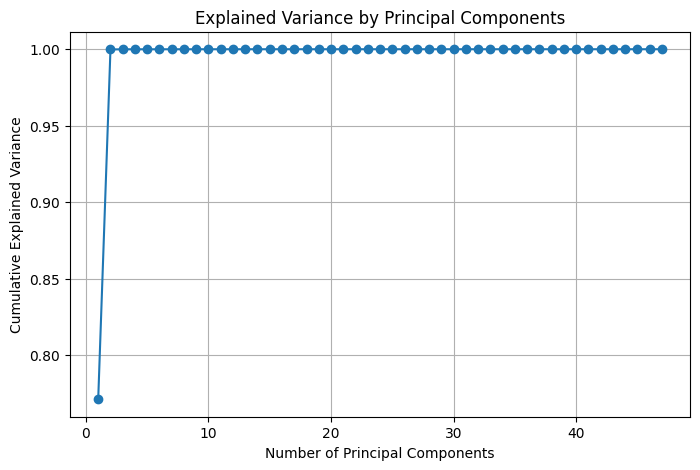

In [161]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid()
plt.show()

In [163]:
# PCA loadings (coefficients linking original features to components)
loadings = pd.DataFrame(pca.components_.T, index=X_scaled.columns, columns=[f'PC{i+1}' for i in range(X_scaled.shape[1])])

# Sort features by contribution to the first few components
print(loadings.abs().sum(axis=1).sort_values(ascending=False))
abs_loadings = loadings.abs().sum(axis=1).sort_values(ascending=False)

zoning_type_Unknown                                           4.141609
zoning_type_Residential                                       4.071956
latitude                                                      4.034024
submarket                                                     3.871776
longitude                                                     3.814230
area                                                          3.778236
zoning_type_Manufacturing                                     3.723912
view_olympics                                                 3.717847
view_sound                                                    3.572641
present_use_29                                                3.456637
subdivision                                                   3.410092
stories                                                       3.329536
view_territorial                                              3.325399
bath_full                                                     3.301890
year_b

In [182]:
abs_loadings_df = abs_loadings.reset_index()
abs_loadings_df.columns = ['Feature', 'Total Contribution']
abs_loadings_df['Total Contribution'] = scaler.fit_transform(abs_loadings_df[['Total Contribution']])
abs_loadings_df

,Feature,Total Contribution
0,zoning_type_Unknown,1.000000
1,zoning_type_Residential,0.977134
2,latitude,0.964682
3,submarket,0.911418
4,longitude,0.892527
5,area,0.880711
6,zoning_type_Manufacturing,0.862877
7,view_olympics,0.860886
8,view_sound,0.813217
9,present_use_29,0.775135


In [183]:
# Merge the two DataFrames on the 'Feature' column
merged_df = pd.merge(abs_loadings_df, sorted_importance_df, on='Feature')

# Display the result
merged_df

,Feature,Total Contribution,Importance
0,zoning_type_Unknown,1.000000,0.000000
1,zoning_type_Residential,0.977134,0.000000
2,latitude,0.964682,0.002105
3,submarket,0.911418,0.010648
4,longitude,0.892527,0.018359
5,area,0.880711,0.017899
6,zoning_type_Manufacturing,0.862877,0.000000
7,view_olympics,0.860886,0.000031
8,view_sound,0.813217,0.000067
9,present_use_29,0.775135,0.000000


In [184]:

#merged_df.drop(columns=['Total Contribution'], inplace=True)
#merged_df.rename(columns={'Scaled_Total_Contribution': 'Total Contribution'}, inplace=True)
# Calculate the average of Importance and Total_Contribution
merged_df['Average_Contribution'] = (merged_df['Importance'] + merged_df['Total Contribution']) / 2

# Sort the resulting DataFrame by Average_Contribution if needed
merged_df = merged_df.sort_values(by='Average_Contribution', ascending=True)


In [185]:
merged_df

,Feature,Total Contribution,Importance,Average_Contribution
46,zoning_type_Parks,0.000000,0.000000,0.000000
45,gara_sqft,0.061947,0.000163,0.031055
44,garb_sqft,0.062542,0.000016,0.031279
43,fbsmt_grade,0.129238,0.000369,0.064804
42,noise_traffic,0.150714,0.000905,0.075809
41,zoning_type_Recreational,0.167852,0.000000,0.083926
40,present_use_6,0.229972,0.000000,0.114986
39,sqft_lot,0.242200,0.001402,0.121801
38,golf,0.249614,0.000031,0.124822
37,land_val,0.290514,0.018150,0.154332


# Optimizing features

In [175]:
gbm = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    n_iter_no_change=10
)

# Perform Recursive Feature Elimination with Cross-Validation
rfecv = RFECV(
    estimator=gbm,
    step=5,  # Remove 5 feature at a time
    cv=2,  
    scoring='r2',
    n_jobs=-1 # Performance metric to optimize
)



In [176]:
# Fit RFECV on the training data
rfecv.fit(X_train, y_train)

# Get the optimal number of features
optimal_features = rfecv.n_features_

# Get selected features
selected_features = X_train.columns[rfecv.support_].tolist()

# Reduce datasets
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"Optimal number of features: {optimal_features}")
print(f"Selected features: {selected_features}")

Optimal number of features: 17
Selected features: ['latitude', 'longitude', 'area', 'city', 'subdivision', 'land_val', 'imp_val', 'year_built', 'year_reno', 'sqft_lot', 'sqft', 'grade', 'stories', 'wfnt', 'noise_traffic', 'view_territorial', 'submarket']


# checking tests after reducing attributes

In [238]:
columns_to_drop = [
    'sqft_1', 'sqft_fbsmt', 'beds', 'bath_full', 'bath_3qtr', 'bath_half', 
    'garb_sqft', 'gara_sqft', 'fbsmt_grade', 'condition', 'golf', 'greenbelt', 
    'view_rainier', 'view_olympics', 'view_cascades', 'view_skyline', 'view_sound', 
    'view_lakewash', 'view_lakesamm', 'view_otherwater', 'view_other'
]

# Add columns prefixed with 'zoning_type' or 'present_use'
columns_to_drop += [col for col in X_scaled.columns if col.startswith('zoning_type') or col.startswith('present_use')]

# Drop the columns
X_reduced = X_scaled.drop(columns=columns_to_drop)

In [254]:
X_reduced.describe()

,latitude,longitude,area,city,subdivision,land_val,imp_val,year_built,year_reno,sqft_lot,sqft,grade,stories,wfnt,noise_traffic,view_territorial,submarket
count,515149.000000,515149.000000,515149.000000,515149.000000,515149.000000,515149.000000,515149.000000,515149.000000,515149.000000,515149.000000,515149.000000,515149.000000,515149.000000,515149.000000,515149.000000,515149.000000,515149.000000
mean,0.668192,0.788865,0.451367,0.450742,0.482050,0.054543,0.046619,0.598355,0.027213,0.013647,0.156407,7.651769,1.528779,0.057436,0.182679,0.200358,0.347479
std,0.238366,0.190592,0.185578,0.136981,0.137690,0.039731,0.031621,0.248178,0.161529,0.018697,0.064853,1.113342,0.525683,0.649801,0.528813,0.696870,0.242494
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.513188,0.814318,0.283574,0.350820,0.379311,0.027804,0.028105,0.427419,0.000000,0.007371,0.108614,7.000000,1.000000,0.000000,0.000000,0.000000,0.154619
50%,0.709984,0.829453,0.466893,0.497108,0.477380,0.045747,0.039877,0.629032,0.000000,0.010757,0.146067,7.000000,1.500000,0.000000,0.000000,0.000000,0.391407
75%,0.861029,0.847031,0.585207,0.497473,0.570720,0.070675,0.057164,0.814516,0.000000,0.014339,0.192509,8.000000,2.000000,0.000000,0.000000,0.000000,0.603992
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.000000,4.500000,9.000000,3.000000,4.000000,1.000000


In [240]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

In [242]:
gbm2 = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    n_iter_no_change=10
)


In [243]:
gbm2.fit(X_train2,y_train2)

GradientBoostingRegressor(n_iter_no_change=10, random_state=42)

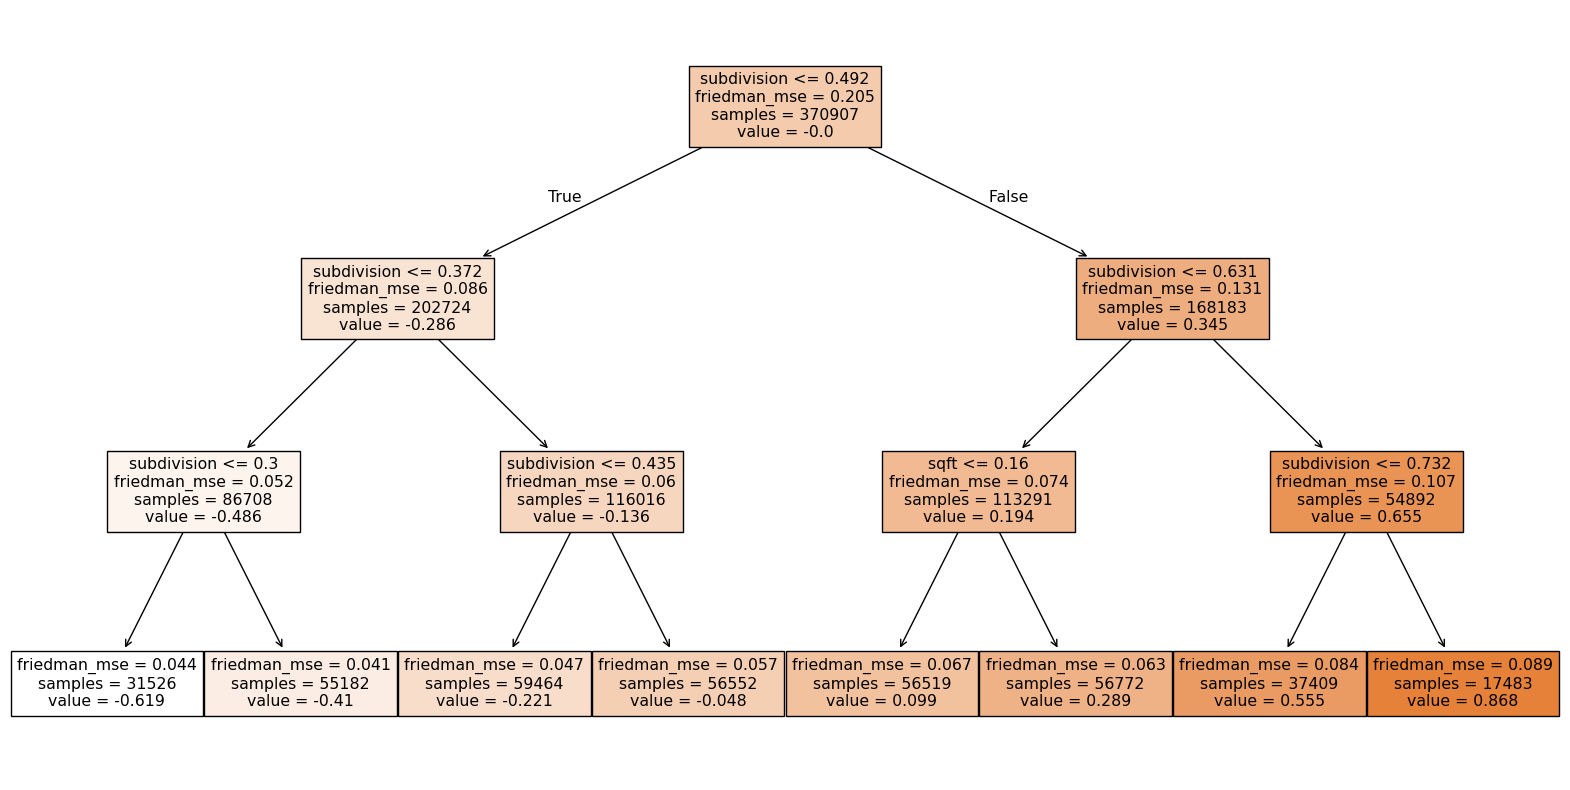

In [244]:
feature_names = X_train2.columns.tolist()
plt.figure(figsize=(20, 10))
plot_tree(gbm2.estimators_[0, 0], feature_names=feature_names, filled=True)
plt.show()


In [245]:
y_pred2 = gbm2.predict(X_test2)

In [246]:
# Evaluation metrics
mse2 = mean_squared_error(y_test2, y_pred2)
r22 = r2_score(y_test2, y_pred2)

print(f"Mean Squared Error (MSE): {mse2}")
print(f"R-squared (R²): {r22}")


Mean Squared Error (MSE): 0.03603664978744306
R-squared (R²): 0.8245805372343682


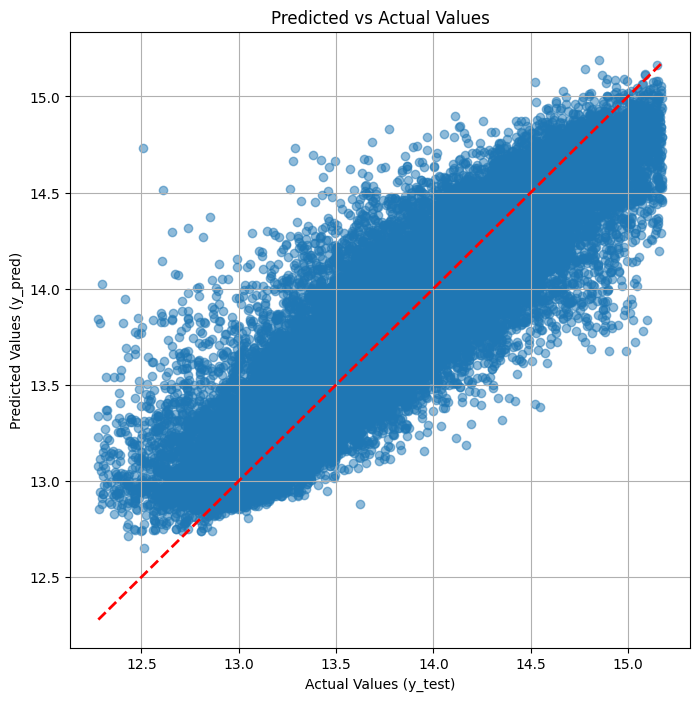

In [247]:
# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test2, y_pred2, alpha=0.5)
plt.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], 'r--', lw=2)  # Diagonal line
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Predicted vs Actual Values')
plt.grid()
plt.show()

Feature importance of the reduced

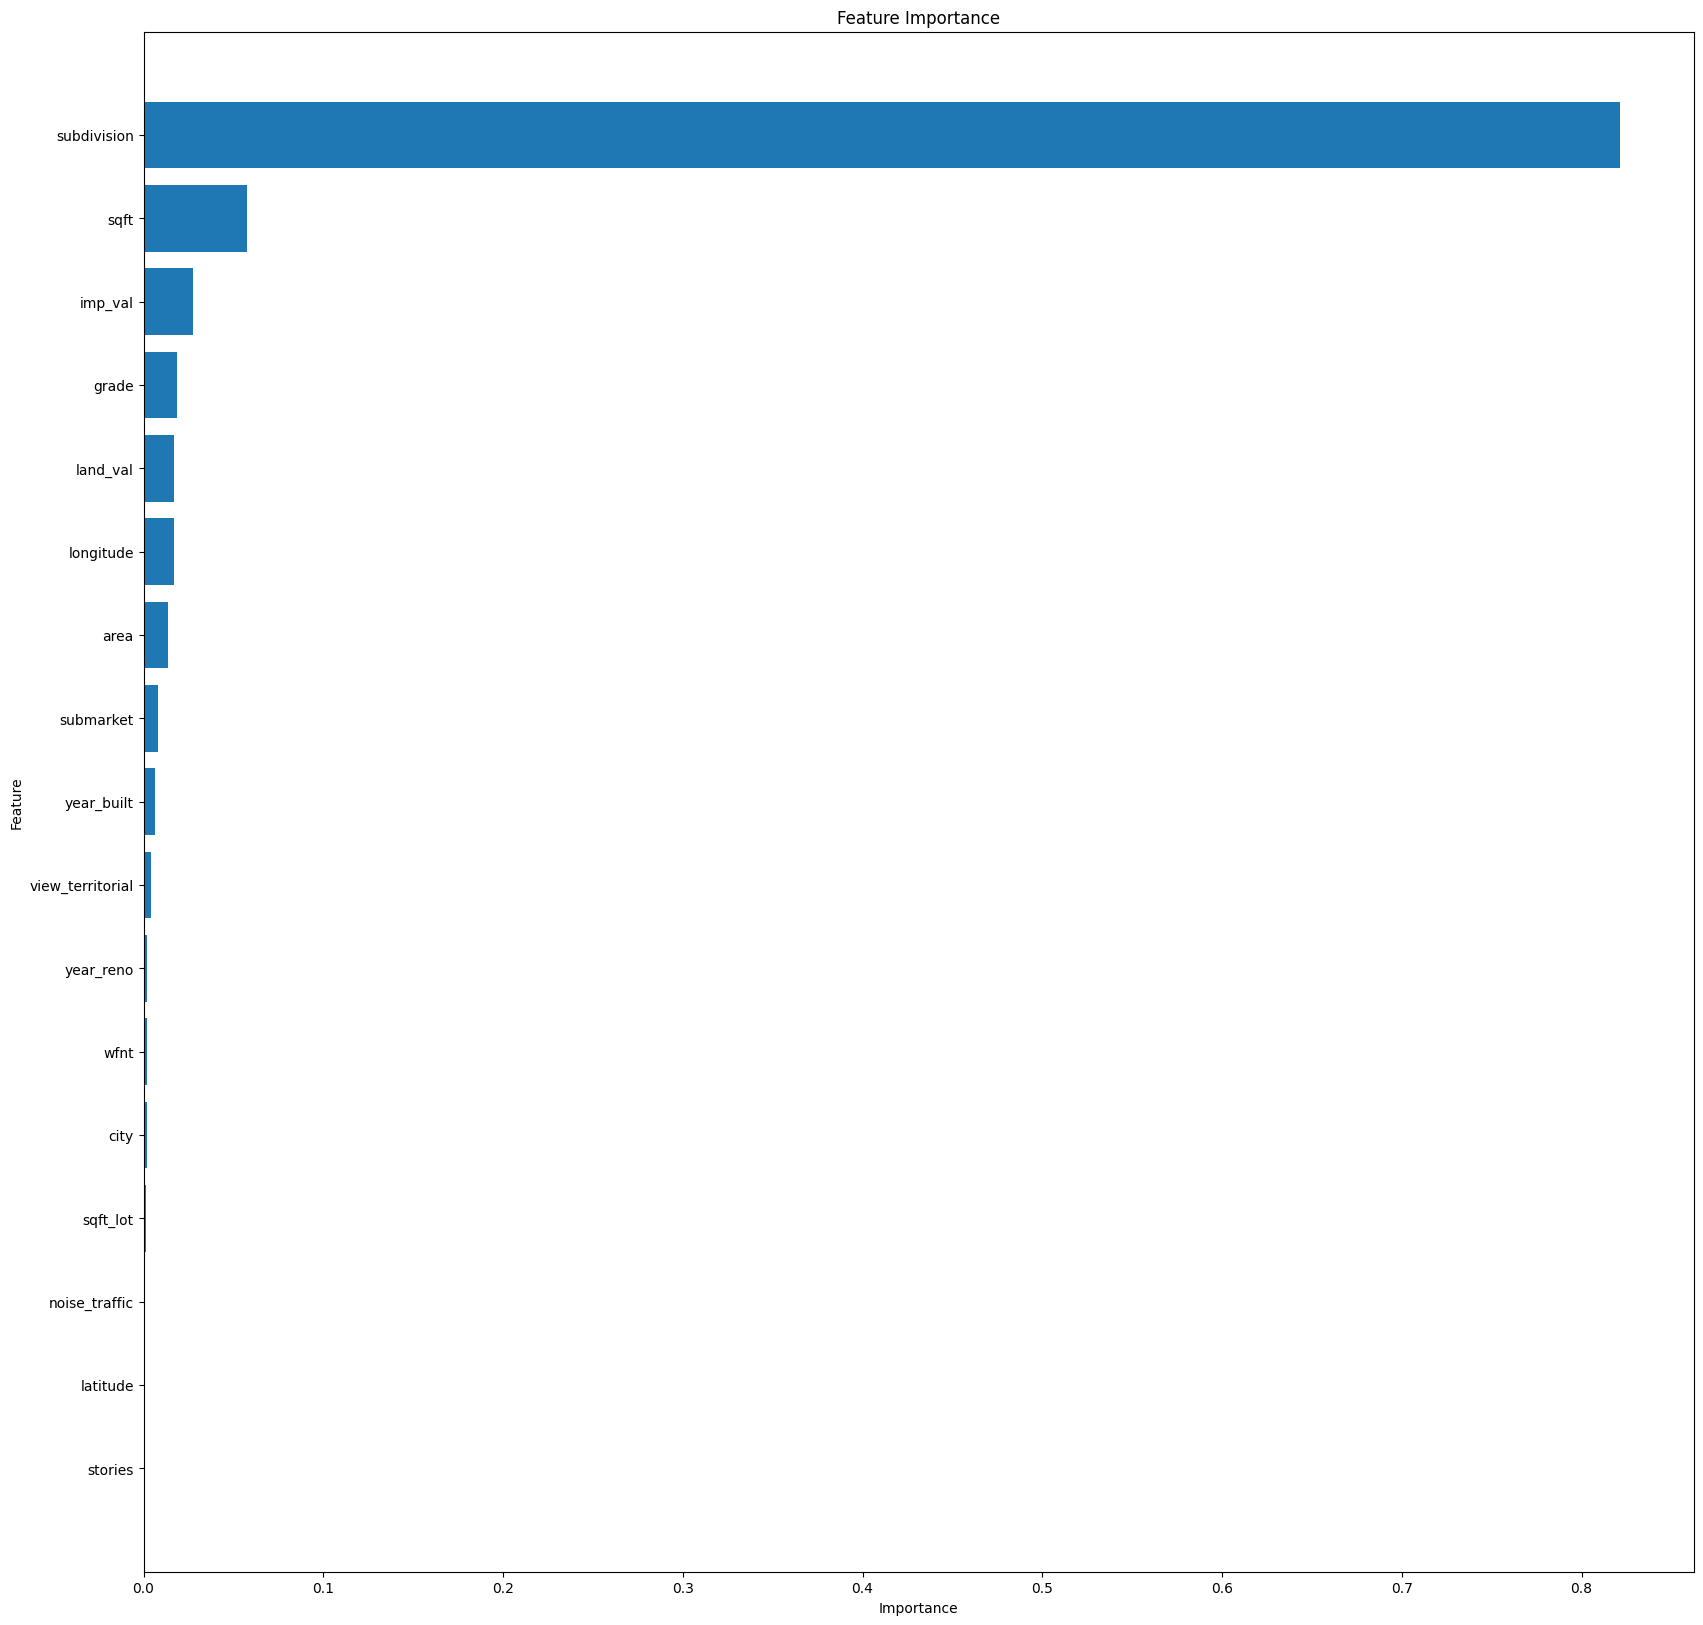

In [251]:
# Sort feature importances
feature_importance2 = pd.Series(gbm2.feature_importances_, index=X_reduced.columns)
sorted_importance2 = feature_importance2.sort_values(ascending=False)

# Plot sorted feature importance
plt.figure(figsize=(20, 20))
plt.barh(sorted_importance2.index, sorted_importance2.values)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

In [252]:
# Convert the Series to a DataFrame
sorted_importance_df2 = sorted_importance2.reset_index()

# Rename the columns
sorted_importance_df2.columns = ['Feature', 'Importance']
sorted_importance_df2['Importance'] =scaler.fit_transform(sorted_importance_df2[['Importance']])
# Display the updated DataFrame
sorted_importance_df2

,Feature,Importance
0,subdivision,1.000000
1,sqft,0.069747
2,imp_val,0.033403
3,grade,0.022014
4,land_val,0.020329
5,longitude,0.019949
6,area,0.016442
7,submarket,0.009151
8,year_built,0.007438
9,view_territorial,0.004677


In [199]:
pca2 = PCA()

In [200]:
X_pca2 = pca2.fit_transform(X_reduced)

In [203]:
# Variance explained by each principal component
explained_variance2 = pca2.explained_variance_ratio_
cumulative_variance2 = np.cumsum(explained_variance2)

print("Explained Variance Ratio:", explained_variance2)
print("Cumulative Variance Ratio:", cumulative_variance2)

Explained Variance Ratio: [7.71102279e-01 2.28762775e-01 8.58346630e-05 1.01202768e-05
 6.12418807e-06 5.80046278e-06 4.56364464e-06 3.91515624e-06
 3.56533503e-06 2.50497937e-06 2.21268500e-06 1.69314007e-06
 1.59525358e-06 9.11625366e-07 8.17944845e-07 7.77105319e-07
 6.54166645e-07 6.09003769e-07 4.64665996e-07 4.00347491e-07
 3.85246870e-07 3.09635220e-07 2.80198906e-07 2.60932845e-07
 2.55769430e-07 2.17911394e-07 1.81810197e-07 1.47863666e-07
 6.48658588e-08 6.01436761e-08 5.79881391e-08 4.98800487e-08
 4.21652245e-08 2.33594588e-08 2.04074182e-08 1.13440488e-08
 5.04025618e-09 2.90433448e-09 2.49738644e-09 1.51388602e-09]
Cumulative Variance Ratio: [0.77110228 0.99986505 0.99995089 0.99996101 0.99996713 0.99997293
 0.9999775  0.99998141 0.99998498 0.99998748 0.9999897  0.99999139
 0.99999298 0.9999939  0.99999471 0.99999549 0.99999614 0.99999675
 0.99999722 0.99999762 0.999998   0.99999831 0.99999859 0.99999885
 0.99999911 0.99999933 0.99999951 0.99999966 0.99999972 0.99999978
 

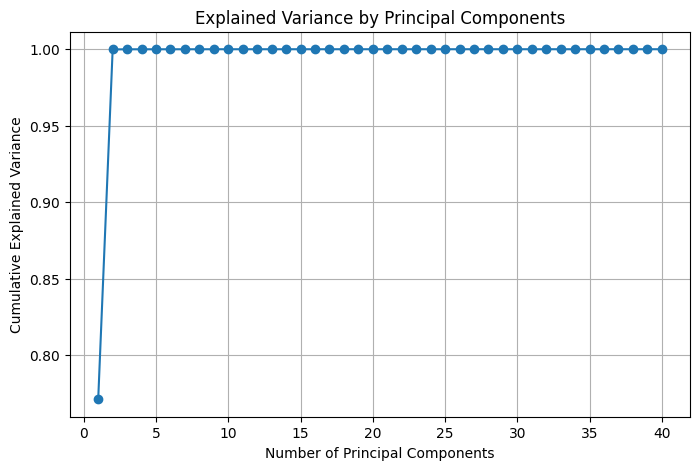

In [204]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance2) + 1), cumulative_variance2, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid()
plt.show()

In [205]:
# PCA loadings (coefficients linking original features to components)
loadings2 = pd.DataFrame(pca2.components_.T, index=X_reduced.columns, columns=[f'PC{i+1}' for i in range(X_reduced.shape[1])])

# Sort features by contribution to the first few components
print(loadings2.abs().sum(axis=1).sort_values(ascending=False))
abs_loadings2 = loadings2.abs().sum(axis=1).sort_values(ascending=False)

view_sound          3.613256
latitude            3.570224
view_olympics       3.534155
submarket           3.423369
present_use_29      3.372561
longitude           3.292339
view_territorial    3.291476
bath_full           3.289307
area                3.283951
stories             3.266083
year_built          3.168440
view_cascades       3.145163
subdivision         3.143875
view_lakewash       3.140359
bath_3qtr           2.999315
grade               2.868713
view_otherwater     2.767879
condition           2.722432
bath_half           2.677100
view_rainier        2.665242
view_lakesamm       2.615354
view_skyline        2.585078
beds                2.559238
sqft                2.528446
view_other          2.491865
sqft_1              2.486513
city                2.444620
imp_val             2.365875
year_reno           2.316850
wfnt                2.272140
sqft_fbsmt          2.146203
land_val            1.909193
sqft_lot            1.804491
greenbelt           1.762319
noise_traffic 

In [206]:
abs_loadings_df2 = abs_loadings2.reset_index()
abs_loadings_df2.columns = ['Feature', 'Total Contribution']
abs_loadings_df2['Total Contribution'] = scaler.fit_transform(abs_loadings_df2[['Total Contribution']])
abs_loadings_df2

,Feature,Total Contribution
0,view_sound,1.000000
1,latitude,0.981531
2,view_olympics,0.966051
3,submarket,0.918505
4,present_use_29,0.896699
5,longitude,0.862269
6,view_territorial,0.861899
7,bath_full,0.860968
8,area,0.858669
9,stories,0.851000


In [207]:
# Merge the two DataFrames on the 'Feature' column
merged_df2 = pd.merge(abs_loadings_df2, sorted_importance_df2, on='Feature')

# Display the result
merged_df2

,Feature,Total Contribution,Importance
0,view_sound,1.000000,0.000032
1,latitude,0.981531,0.000780
2,view_olympics,0.966051,0.000000
3,submarket,0.918505,0.009650
4,present_use_29,0.896699,0.000050
5,longitude,0.862269,0.020039
6,view_territorial,0.861899,0.004967
7,bath_full,0.860968,0.000000
8,area,0.858669,0.017080
9,stories,0.851000,0.000393


In [208]:
merged_df2['Average_Contribution'] = (merged_df2['Importance'] + merged_df2['Total Contribution']) / 2

# Sort the resulting DataFrame by Average_Contribution if needed
merged_df2 = merged_df2.sort_values(by='Average_Contribution', ascending=True)
merged_df2

,Feature,Total Contribution,Importance,Average_Contribution
39,gara_sqft,0.000000,0.000149,0.000075
38,garb_sqft,0.001013,0.000000,0.000507
37,golf,0.044612,0.000066,0.022339
36,present_use_6,0.050115,0.000000,0.025058
35,fbsmt_grade,0.070210,0.000354,0.035282
34,noise_traffic,0.080033,0.000973,0.040503
33,greenbelt,0.205617,0.000018,0.102817
32,sqft_lot,0.223716,0.001316,0.112516
31,land_val,0.268652,0.020888,0.144770
30,sqft_fbsmt,0.370372,0.000000,0.185186


In [210]:
selected_features = merged_df2[
    (merged_df2['Total Contribution'] > 0.1) |
    (merged_df2['Importance'] > 0.01) |
    (merged_df2['Average_Contribution'] > 0.05)
]
selected_features


,Feature,Total Contribution,Importance,Average_Contribution
33,greenbelt,0.205617,0.000018,0.102817
32,sqft_lot,0.223716,0.001316,0.112516
31,land_val,0.268652,0.020888,0.144770
30,sqft_fbsmt,0.370372,0.000000,0.185186
29,wfnt,0.424421,0.002332,0.213377
28,year_reno,0.443610,0.002765,0.223187
27,imp_val,0.464650,0.033155,0.248902
26,city,0.498446,0.002230,0.250338
25,sqft_1,0.516426,0.000437,0.258431
24,view_other,0.518723,0.000000,0.259361


In [218]:
# Original list of features (assuming you have this stored in a list)
all_features = [
    'latitude', 'longitude', 'area', 'city', 'subdivision', 'zoning_type', 'present_use', 
    'land_val', 'imp_val', 'year_built', 'year_reno', 'sqft_lot', 'sqft', 'sqft_1', 
    'sqft_fbsmt', 'stories', 'beds', 'bath_full', 'bath_3qtr', 'bath_half', 'garb_sqft', 
    'gara_sqft', 'grade', 'fbsmt_grade', 'condition', 'wfnt', 'golf', 'greenbelt', 
    'noise_traffic', 'view_rainier', 'view_olympics', 'view_cascades', 'view_territorial', 
    'view_skyline', 'view_sound', 'view_lakewash', 'view_lakesamm', 'view_otherwater', 
    'view_other', 'submarket'
]

# Selected features from your model
selected_features = [
    'latitude', 'longitude', 'area', 'city', 'subdivision', 'land_val', 'imp_val', 
    'year_built', 'year_reno', 'sqft_lot', 'sqft', 'grade', 'stories', 'wfnt', 
    'noise_traffic', 'view_territorial', 'submarket'
]

# Identify unused features
unused_features = [feature for feature in all_features if feature not in selected_features]

# Print unused features
print("Unused features:", unused_features)


Unused features: ['zoning_type', 'present_use', 'sqft_1', 'sqft_fbsmt', 'beds', 'bath_full', 'bath_3qtr', 'bath_half', 'garb_sqft', 'gara_sqft', 'fbsmt_grade', 'condition', 'golf', 'greenbelt', 'view_rainier', 'view_olympics', 'view_cascades', 'view_skyline', 'view_sound', 'view_lakewash', 'view_lakesamm', 'view_otherwater', 'view_other']
